# Object Detection with Detectron2 Framework
## Transfer Learning Approach using Pre-Trained Faster R-CNN with FPN Backbone Model (R50-FPN)

In [265]:
import detectron2

from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2 import structures

import torch
import pandas as pd
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
import pickle
import os
import random

import warnings

In [2]:
setup_logger()
warnings.filterwarnings('ignore')

In [3]:
# Device agnostic code
device= 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, torch.cuda.get_device_name())

cuda NVIDIA GeForce RTX 3090


### User Defined Function

In [4]:
def visualizeResult(image, output):
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
              scale=1.2)
    v = v.draw_instance_predictions(output["instances"].to("cpu"))
    plt.figure(figsize=(14,10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

def get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, test_dataset_name, num_classes, device, output_dir):
    cfg = get_cfg()

    cfg.merge_from_file(model_zoo.get_config_file(config_file_path))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = ()

    cfg.DATALOADER.NUM_WORKERS = 2

    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 1500
    cfg.SOLVER.STEPS = []

    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.DEVICE = device
    cfg.OUTPUT_DIR = output_dir

    return cfg

### Get metadata for the COCO dataset

In [5]:
metadata = MetadataCatalog.get("coco_2017_val")

In [6]:
class_names = metadata.get("thing_classes")

In [7]:
print(len(class_names))
print(class_names)

80
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

#### Cerate Predictor

In [9]:
predictor = DefaultPredictor(cfg)

[06/30 21:16:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl ...


#### Make Prediction

In [10]:
img = cv2.imread('./data/sample_data/1.jpg')

In [11]:
output = predictor(img)

#### Visualize The Result

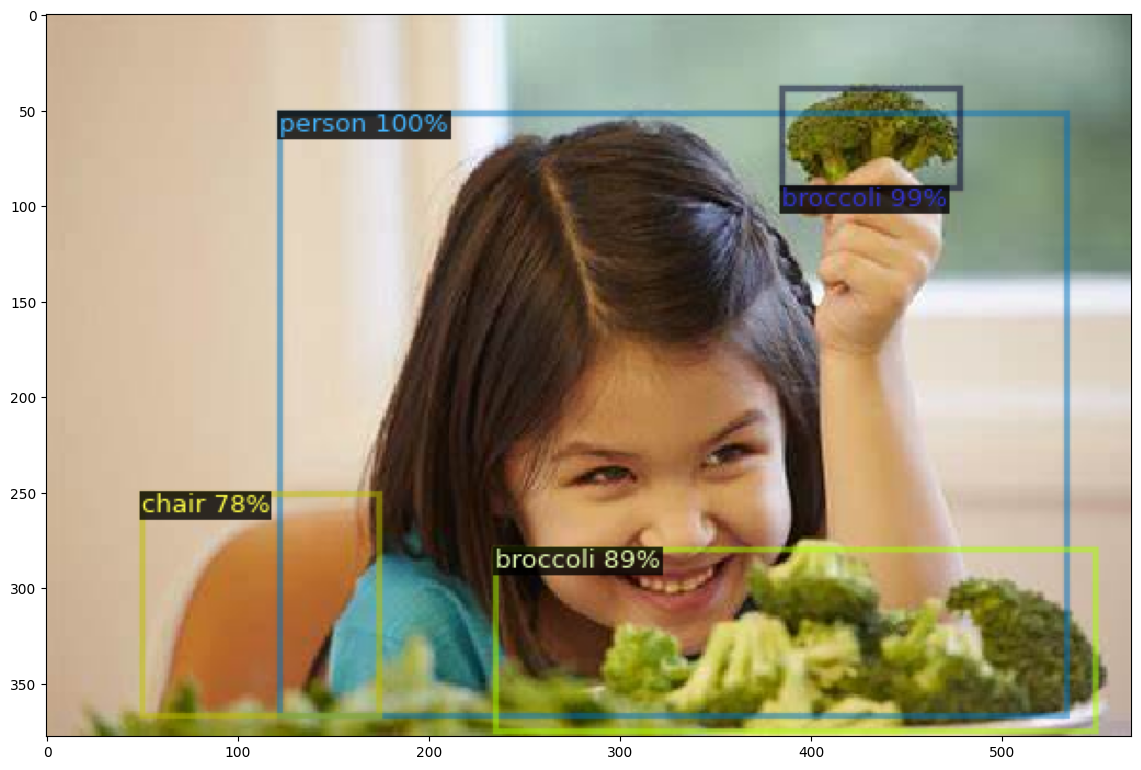

In [12]:
visualizeResult(img, output)

In [13]:
# Get the predicted class labels for each instance in the image
predicted_classes = output["instances"].pred_classes.tolist()

# Map the predicted class labels to class names
predicted_class_names = [class_names[class_id] for class_id in predicted_classes]

In [14]:
# Print the predicted class names
print("Predicted Class Names:", predicted_class_names)
print(output["instances"].pred_boxes)

Predicted Class Names: ['person', 'broccoli', 'broccoli', 'chair']
Boxes(tensor([[101.8289,  43.4962, 444.9674, 305.5771],
        [320.9112,  32.1048, 398.6628,  75.4913],
        [195.8196, 233.6495, 457.3973, 312.1735],
        [ 41.2923, 209.2197, 145.2540, 305.7210]], device='cuda:0'))


### Custom Dataset

- The ID Card used is Indonesian ID Card
- There are two annotations on the ID Card images i.e. ID Card and ID Card Hologram

In [15]:
dataPath = "./data/"

#### Register ID Card data (COCO format) for both train and validation data

In [16]:
register_coco_instances("id_card_train_data", {}, "./train.json", "./data/all_data")

In [17]:
register_coco_instances("id_card_val_data", {}, "./val.json", "./data/all_data")

In [18]:
id_card_train_metadata = MetadataCatalog.get("id_card_train_data")
dataset_dicts = DatasetCatalog.get("id_card_train_data")

[06/30 21:16:15 d2.data.datasets.coco]: Loaded 168 images in COCO format from ./train.json


#### Observe Our Images Data Including Their Annotations

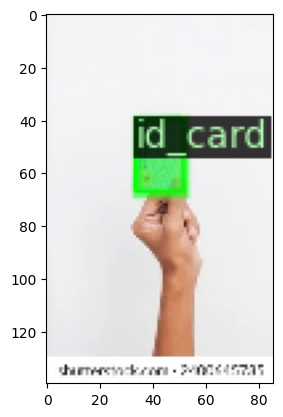

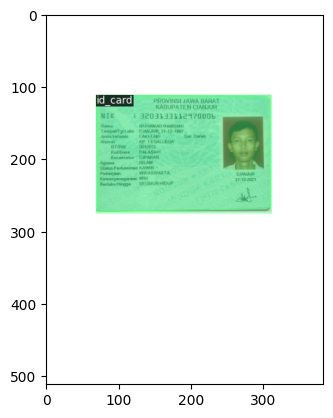

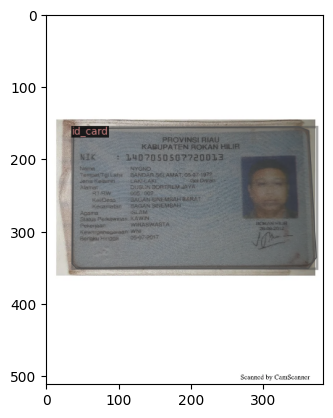

In [19]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=id_card_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

#### Model Training on Custom Dataset

In [20]:
cfg = get_train_cfg("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml", 
                    "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml", 
                    "id_card_train_data", "id_card_val_data", 2, device, 
                    "./model")

with open("./model/OD_cfg.pickle", 'wb') as f:
    pickle.dump(cfg, f, protocol=pickle.HIGHEST_PROTOCOL)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

trainer.train()

[06/30 21:16:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[06/30 21:16:16 d2.engine.train_loop]: Starting training from iteration 0
[06/30 21:16:25 d2.utils.events]:  eta: 0:09:46  iter: 19  total_loss: 1.674  loss_cls: 1.155  loss_box_reg: 0.4717  loss_rpn_cls: 0.006724  loss_rpn_loc: 0.01959    time: 0.3903  last_time: 0.4088  data_time: 0.0259  last_data_time: 0.0078   lr: 4.9953e-06  max_mem: 6695M
[06/30 21:16:33 d2.utils.events]:  eta: 0:09:34  iter: 39  total_loss: 1.56  loss_cls: 1.052  loss_box_reg: 0.4911  loss_rpn_cls: 0.008204  loss_rpn_loc: 0.01358    time: 0.3839  last_time: 0.3710  data_time: 0.0221  last_data_time: 0.0378   lr: 9.9902e-06  max_mem: 6775M
[06/30 21:16:40 d2.utils.events]:  eta: 0:09:15  iter: 59  total_loss: 1.395  loss_cls: 0.8525  loss_box_reg: 0.5227  loss_rpn_cls: 0.009412  loss_rpn_loc: 0.02224    time: 0.3790  last_time: 0.3654  data_time: 0.0173  last_data_time: 0.0226   lr: 1.4985e-05  max_mem: 6778M
[06/30 21:16:47 d2.utils.events]:  eta: 0:09:02  iter: 79  total_loss: 1.215  loss_cls: 0.6432  loss_box

The warning messages above just tell us that the model setup is different from the pre-trained model. It does not affect the model performance during training, it's expected behaviour.

In [21]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir ./model

### Inference

In [22]:
# Load the model and setup the threshold
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set threshold
predictor = DefaultPredictor(cfg)

[06/30 21:25:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./model/model_final.pth ...


In [23]:
id_card_metadata = MetadataCatalog.get("id_card_val_data")
dataset_dicts = DatasetCatalog.get("id_card_val_data")

[06/30 21:25:44 d2.data.datasets.coco]: Loaded 42 images in COCO format from ./val.json


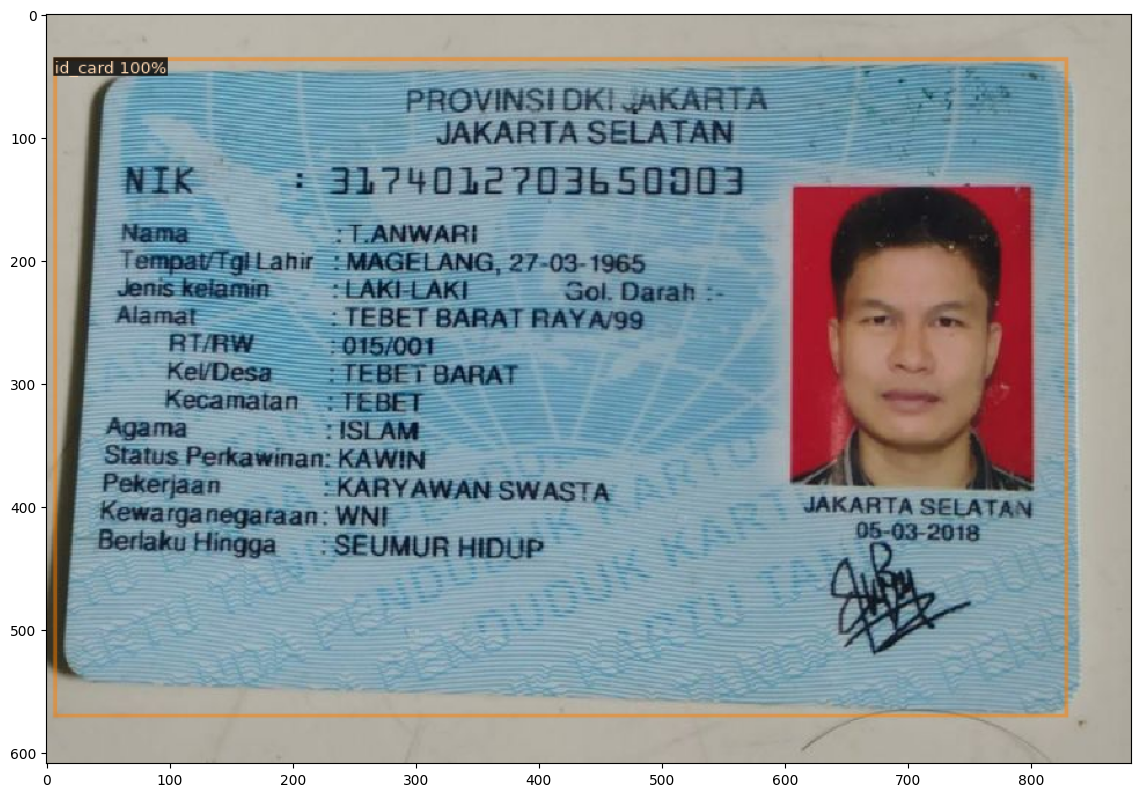

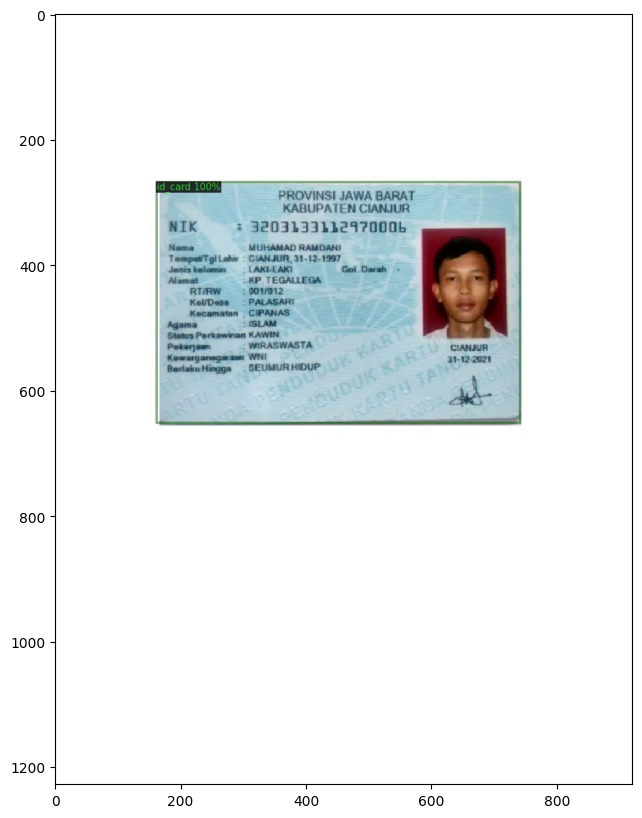

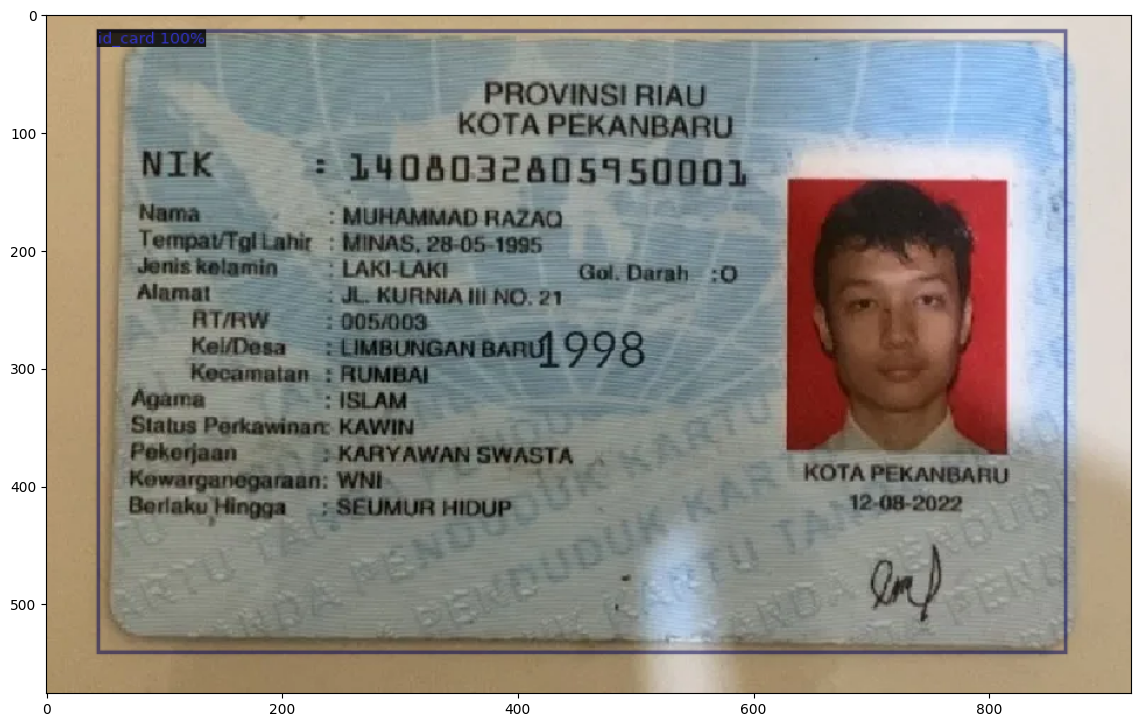

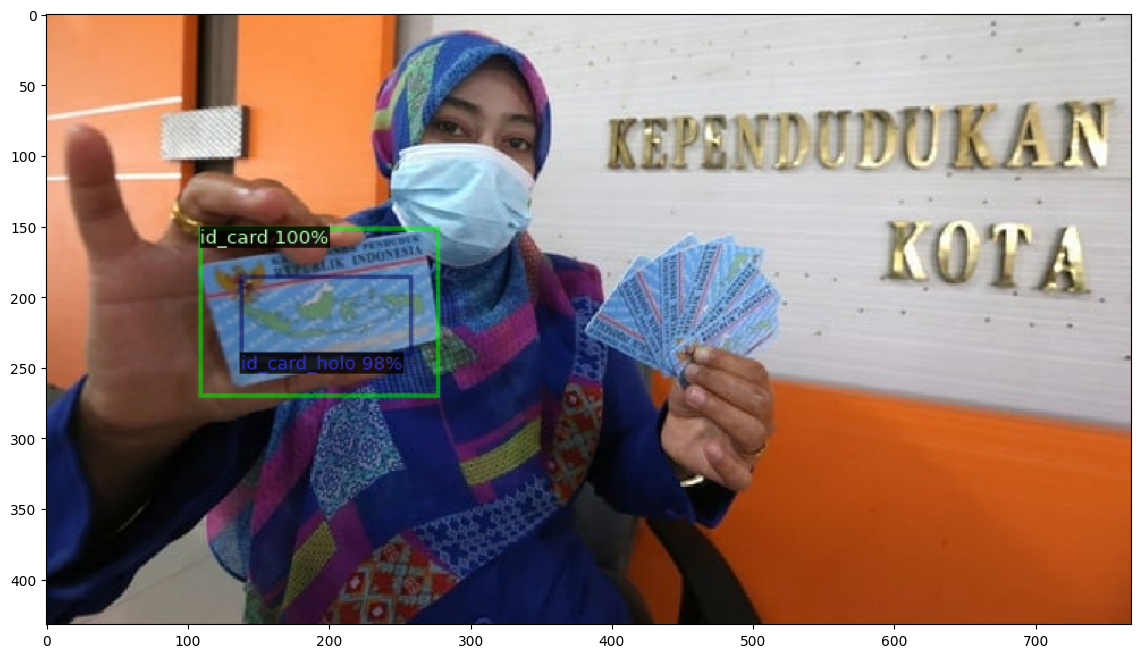

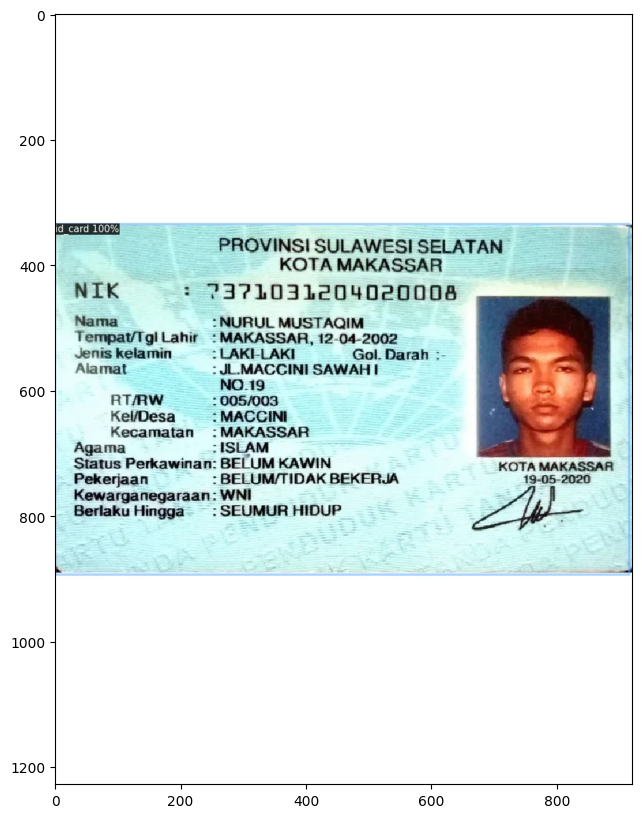

In [25]:
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    output = predictor(img)
    visualizeResult(img, output)

### Evaluation Metrics

#### Intersection Over Union (IOU)

In [266]:
result_list = []
for data in dataset_dicts:
    for i in range(len(data.get('annotations'))):
        result = {}
        result['file_name']= data['file_name']
        img_path = data['file_name']
        img= cv2.imread(img_path)
        bboxes_gt = data.get('annotations')[i]['bbox']
        bboxes_gt = structures.Boxes(torch.Tensor([bboxes_gt]))
        result['bboxes_ground_truth'] = data.get('annotations')[i]['bbox']
        
        output = predictor(img)
        if len(data.get('annotations')) == len(output['instances'].pred_classes):
            result['class_name'] = 'id_card' if output['instances'].pred_classes.cpu().numpy()[i] == 0 else "id_card_holo"
            bboxes_pred = output["instances"].pred_boxes[i]
            result['bboxes_pred'] = output["instances"].pred_boxes[i].tensor.squeeze().cpu().numpy()
            iou_matrix = structures.pairwise_iou(bboxes_gt.to('cpu'), bboxes_pred.to('cpu'))
            result['iou_matrix'] = iou_matrix.squeeze().cpu().numpy()
            result_list.append(result)

iou_df = pd.DataFrame(result_list)

In [272]:
iou_df.head()

file_name                                bboxes_ground_truth  \
0  ./data/all_data/64.jpg  [8.190376569037676, 1.2489539748954002, 514.22...   
1  ./data/all_data/64.jpg  [72.62552301255232, 80.32845188284519, 391.631...   
2  ./data/all_data/23.jpg  [136.2151898734177, 225.9240506329114, 486.708...   
3  ./data/all_data/76.jpg  [73.84105960264898, 238.41059602649005, 484.76...   
4  ./data/all_data/76.jpg  [119.53642384105959, 319.8675496688742, 398.01...   

     class_name                                  bboxes_pred  iou_matrix  
0       id_card   [21.74169, 1.8904219, 518.2044, 287.90717]  0.94715893  
1  id_card_holo   [60.684822, 64.49797, 468.05133, 232.5015]     0.28087  
2       id_card   [135.22047, 223.65175, 617.7277, 543.7422]  0.21837567  
3       id_card  [72.289536, 234.14682, 550.3729, 522.63226]  0.13812059  
4  id_card_holo  [128.39441, 308.84317, 519.6498, 464.48456]         0.0